<a href="https://colab.research.google.com/github/MaxRodrigues91/INFNET_FinalProject/blob/main/Segmenta%C3%A7%C3%A3o_de_Clientes_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color='green'>**Bootcamp Projeto Final** 

# *Como segmentar diferentes clientes em diferentes grupos de acordo com sua similaridade ?*


#### **Alunos** :  *Maxwell Maciel e Vinicius Batista*

### **Índice**
* [Introdução: Problema do Negócio](#introduction)
* [Descrição e Exploração do Dataset](#data)
* [Metodologia e Análises](#methodology)
* [Conclusão](#conclusao)

## **1. Introdução: Problema do Negócio <a name="introduction"></a>**

 A segmentação de mercado surgiu em 1956, utilizada por Wendell Smith como uma estratégia para aumentar o número de vendas de seus produtos. Apesar de ser um tema abordado há mais de 60 anos, ainda permanece muito atual, sendo amplamente aplicado as mais diversas empresas. A premissa básica segmentação de mercado é que as demandas são heterogéneas, podendo assim serem divididas em grupos menores, com mais similaridades tanto em suas características quanto em seu comportamento de compra. Assim, conhecer esses grupos menores permite que as empresas ofereçam produtos, serviços e campanhas publicitárias mais direcionadas e consequentemente mais atrativas para uma fatia de público específico. As áreas comumente mais ligadas a segmentação de mercado são o marketing e o design de produtos, justamente por serem as áreas que desenvolvem o seu trabalho com o objetivo de atingir o seu público.
 
Neste trabalho faremos uma análise exploratória dos dados e aplicaremos algoritmos de Machine Learning de clusterização com o objetivo de segmentar os clientes de um shopping de acordo com sua similaridade, para identificar potenciais clientes, as suas características e seus padrões de consumo. O banco de dados a ser analisado é de um período pré-pandemia do (covid-19). Após essa análise, o shopping poderá utilizar os resultados obtidos a fim de aumentar a assertividade do direcionamento das suas campanhas junto ao time de marketing, além disso o shopping poderá promover eventos direcionados a fatia de clientes com maior potencial de compra para atraí-los. Além de conseguir selecionar melhor as lojas que de fato atingirão o seu público, gerando assim valor a todos os envolvidos.


## **2. Descrição e Exploração do dados<a name="data"></a>**

Para examinar a pesquisa proposta, foi utilizado a seguinte fonte de dados:

*Link*: <font color='red'>https://drive.google.com/file/d/19BOhwz52NUY3dg8XErVYglctpr5sjTy4/view


*Descrição dos dados:*

*   **Gender** - *Gênero do cliente;*
*   **Age**- *Idade do cliente;*
*   **Annual Income (k$)**- *Renda anual do cliente;*
*   **Spending Score (1-100)**- *Pontuação atribuída pelo shopping com base no comportamento do cliente e natureza dos gastos.*








*Primeiro vamos importar as bibliotecas que utilizaremos ao logo da pesquisa*

In [1]:
!pip install seaborn
!pip install plotly
!pip install rogeriopradoj-paretochart 

  Created wheel for rogeriopradoj-paretochart: filename=rogeriopradoj_paretochart-2.0.0-cp37-none-any.whl size=6377 sha256=171452fce7429fac472adf46986248e8508fe79ba4d226e02140e9ffd8530976
  Stored in directory: /root/.cache/pip/wheels/09/21/81/73b9478586fcb9ee2ec8bc3f6d077edebfddced56249c3c6de
Successfully built rogeriopradoj-paretochart


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

import plotly.express as px
import warnings


from paretochart.paretochart import pareto
warnings.filterwarnings("ignore")
print('Bibliotecas importadas.')

Bibliotecas importadas.


### **Carregando os dados**

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/vbatistams/Projeto_Final/main/Mall_Customers.csv")

In [10]:
df.head(2)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81


In [ ]:
# dropar a coluna "costumer ID"
df.drop('CustomerID', axis = 1, inplace = True) 
#Renomear as colunas para nomes mais condizentes
df = df.rename(columns={'Annual Income (k$)':'Annual_Income','Spending Score (1-100)':'Spending_Score'}) 
df.columns = df.columns.str.lower()
df.head(2)

,gender,age,annual_income,spending_score
0,Male,19,15,39
1,Male,21,15,81


### **Exploração e Mapeamento dos dados**

In [ ]:
#Verificar dados faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [ ]:
df.groupby("gender").age.agg('count')

gender
Female    112
Male       88
Name: age, dtype: int64

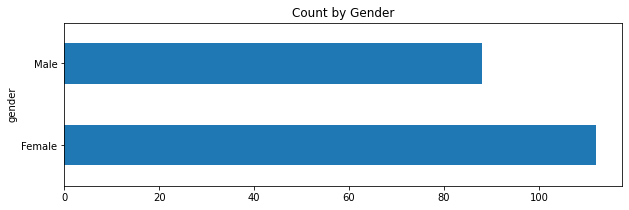

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,3))
df.groupby("gender").age.agg('count').plot(kind='barh',ax=ax).set_title('Count by Gender')
plt.show()

56% dos dados são de mulheres e 44% são de homens

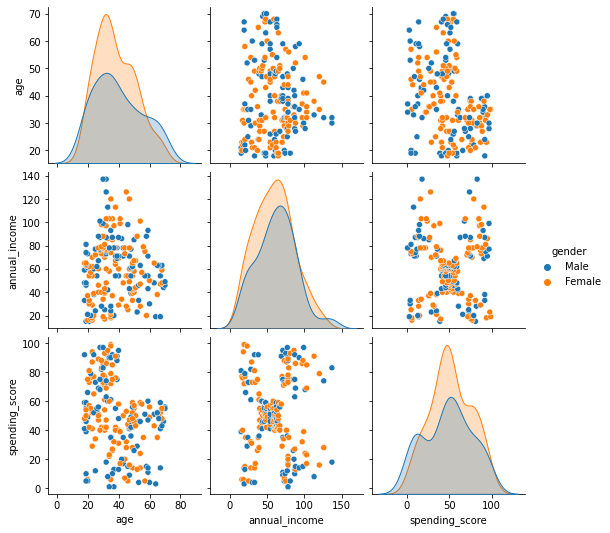

In [ ]:
# Verificar a distribuição dos dados por gênero
sns.pairplot(df ,hue="gender")
plt.show()

In [ ]:
# Definindo 1 para homens e 0 para mulheres
df1=pd.get_dummies(df, drop_first=True) 
df1.head(3)

,age,annual_income,spending_score,gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0


In [ ]:
df1 = df1.rename(columns={'gender_Male':'gender'}) 
df1.head(3)

,age,annual_income,spending_score,gender
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0


Criaremos um df para adicionar as faixas de idade

In [ ]:
df_faixa = df1.copy()

In [ ]:
df_faixa['faixa_etaria'] = 0
df_faixa['faixa_etaria'][(df_faixa['age'] >= 18) & (df_faixa['age'] <= 25)] = 'Geração Z'
df_faixa['faixa_etaria'][(df_faixa['age'] >= 26) & (df_faixa['age'] <=40 )]= 'Geração Y'
df_faixa['faixa_etaria'][(df_faixa['age'] >=41)] ='Cringe'
df_faixa

,age,annual_income,spending_score,gender,faixa_etaria
0,19,15,39,1,Geração Z
1,21,15,81,1,Geração Z
2,20,16,6,0,Geração Z
3,23,16,77,0,Geração Z
4,31,17,40,0,Geração Y
...,...,...,...,...,...
195,35,120,79,0,Geração Y
196,45,126,28,0,Cringe
197,32,126,74,1,Geração Y
198,32,137,18,1,Geração Y


### **Dados Gênero Masculino:**

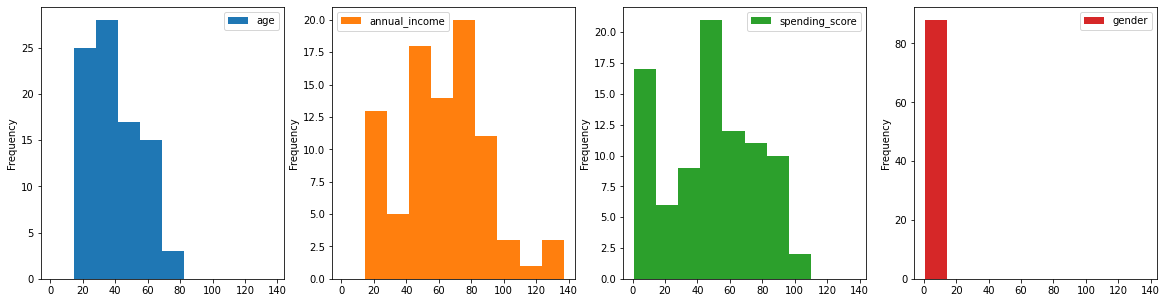

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20, 5))
sdf2 = df1.groupby(by="gender")
sdf2.get_group(1).plot(kind='hist',ax=ax, subplots=True, bins=10)
plt.show()

In [ ]:
df_masc = df1.loc[(df1['gender'] == 1)]
df_masc.describe()

,age,annual_income,spending_score,gender
count,88.000000,88.000000,88.000000,88.0
mean,39.806818,62.227273,48.511364,1.0
std,15.514812,26.638373,27.896770,0.0
min,18.000000,15.000000,1.000000,1.0
25%,27.750000,45.500000,24.500000,1.0
50%,37.000000,62.500000,50.000000,1.0
75%,50.500000,78.000000,70.000000,1.0
max,70.000000,137.000000,97.000000,1.0


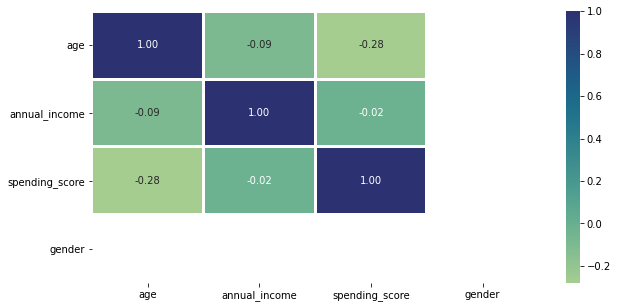

In [ ]:
scaled_data1 = pd.DataFrame(StandardScaler().fit_transform(df_masc), columns=df_masc.columns, index=df_masc.index)

plt.figure(figsize=(10,5))
sns.heatmap(scaled_data1.corr(),annot=True,cmap="crest",fmt='.2f',linewidths=2)
plt.show()

*Conforme podemos observar acima, a maior correlação existente entre as variáveis é a de spending_score com age. No entanto, a correlação ainda é baixa(-0,28).*

In [ ]:
df_masc['faixa_etaria']=df_faixa['faixa_etaria']
df_masc

,age,annual_income,spending_score,gender,faixa_etaria
0,19,15,39,1,Geração Z
1,21,15,81,1,Geração Z
8,64,19,3,1,Cringe
10,67,19,14,1,Cringe
14,37,20,13,1,Geração Y
...,...,...,...,...,...
187,28,101,68,1,Geração Y
192,33,113,8,1,Geração Y
197,32,126,74,1,Geração Y
198,32,137,18,1,Geração Y


In [ ]:
df_masc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             88 non-null     int64 
 1   annual_income   88 non-null     int64 
 2   spending_score  88 non-null     int64 
 3   gender          88 non-null     uint8 
 4   faixa_etaria    88 non-null     object
dtypes: int64(3), object(1), uint8(1)
memory usage: 3.5+ KB


In [ ]:
px.bar(data_frame= df_masc, x ='faixa_etaria', y = 'annual_income', 
       color = 'annual_income', title = 'Renda anual Clientes Gênero Masculino',category_orders={"faixa_etaria": ["Geração Z", "Geração Y", "Cringe"]})

*Como podemos verficar no gráfico acima, os clientes da geração Y são os clientes que possuem a maior renda anual, seguidos pelos clientes Cringe e Geração Z.*

In [ ]:
px.bar(data_frame= df_masc, x = 'faixa_etaria', y = 'spending_score', 
       color = 'spending_score', title = 'Pontuação Clientes Gênero Masculino',category_orders={"faixa_etaria": ["Geração Z", "Geração Y", "Cringe"]})

*Como podemos obersvar os clientes com maior score estão concentrados entre nageração Y e Z. Algo interessante é a geração Z possui é composta por um grupo cerca de 50% menor que a Cringe, mas possuem um score maior.*

In [ ]:
df_masc.groupby('faixa_etaria')['spending_score','annual_income'].describe()

spending_score                        ... annual_income              
                      count       mean        std  ...           50%    75%    max
faixa_etaria                                       ...                            
Cringe                 35.0  34.942857  17.995004  ...          60.0  71.00   98.0
Geração Y              35.0  60.885714  30.287613  ...          77.0  87.00  137.0
Geração Z              18.0  50.833333  28.291030  ...          48.0  63.25   81.0

[3 rows x 16 columns]

**Características do grupo do Gênero masculino**



**Cringe** : 
Clientes que possuem um spending_score menor que 60 e possuem uma média de renda anual de 57,5(k).

**Geração Y** : 
Clientes que possuem um spending_score de até que 97 (maior score do grupo masculino), é onde encontra-se o maior desvio padrão. Possuem uma média de renda anual de 74,45(k) e maior renda anual do grupo masculino.

**Geração Z** : Número de amostras 50% menor que os demais grupos.Possuem um spending_score de até que 92 (segundo maior do grupo masculino). Possuem a menor média de renda anual de 47,6(k) e a menor renda anual.



### **Dados Gênero Feminino:**

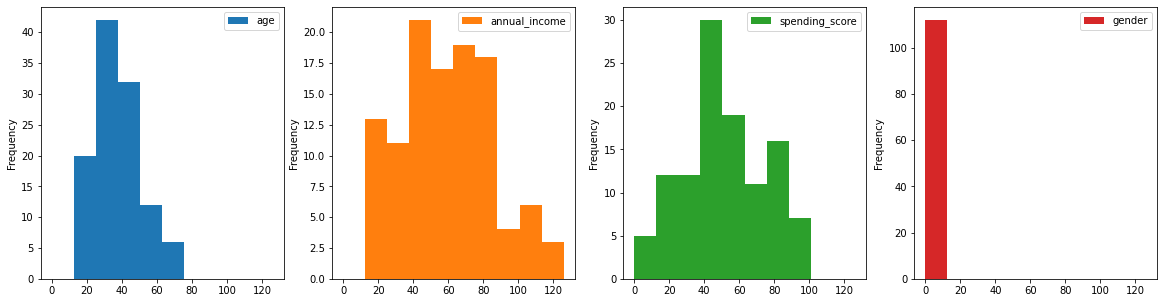

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20, 5))
sdf2 = df1.groupby(by="gender")
sdf2.get_group(0).plot(kind='hist',ax=ax, subplots=True, bins=10)
plt.show()

In [ ]:
df_fem = df1.loc[(df1['gender'] == 0)]
df_fem.describe()

,age,annual_income,spending_score,gender
count,112.000000,112.000000,112.000000,112.0
mean,38.098214,59.250000,51.526786,0.0
std,12.644095,26.011952,24.114950,0.0
min,18.000000,16.000000,5.000000,0.0
25%,29.000000,39.750000,35.000000,0.0
50%,35.000000,60.000000,50.000000,0.0
75%,47.500000,77.250000,73.000000,0.0
max,68.000000,126.000000,99.000000,0.0


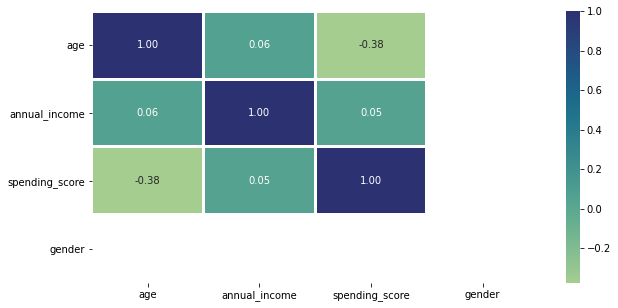

In [ ]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(df_fem),
                           columns=df_fem.columns, index=df_fem.index)

plt.figure(figsize=(10,5))
sns.heatmap(scaled_data.corr(),annot=True,cmap="crest",fmt='.2f',linewidths=2)
plt.show()

*Conforme podemos observar acima, a maior correlação existente entre as variáveis é a de spending_score com age. No entanto, a correlação ainda é baixa(-0,38).*

In [ ]:
df_fem['faixa_etaria']=df_faixa['faixa_etaria']
df_fem

,age,annual_income,spending_score,gender,faixa_etaria
2,20,16,6,0,Geração Z
3,23,16,77,0,Geração Z
4,31,17,40,0,Geração Y
5,22,17,76,0,Geração Z
6,35,18,6,0,Geração Y
...,...,...,...,...,...
191,32,103,69,0,Geração Y
193,38,113,91,0,Geração Y
194,47,120,16,0,Cringe
195,35,120,79,0,Geração Y


In [ ]:
px.bar(data_frame= df_fem, x = 'faixa_etaria', y = 'annual_income', 
       color = 'annual_income',
       title = 'Renda anual Clientes Gênero Feminino',category_orders={"faixa_etaria": ["Geração Z", "Geração Y", "Cringe"]})

*Como podemos observar a maior concentração de renda anual está na geração Cringe.*

In [ ]:
px.bar(data_frame= df_fem, x = "faixa_etaria", y = "spending_score", 
       color = "spending_score", title = 'Pontuação Clientes Gênero Feminino',category_orders={"faixa_etaria": ["Geração Z", "Geração Y", "Cringe"]})


*As gerações Y e Z concentram os maiores scores.*



In [ ]:
df_fem.groupby('faixa_etaria')['spending_score','annual_income'].describe()

spending_score                        ... annual_income              
                      count       mean        std  ...           50%    75%    max
faixa_etaria                                       ...                            
Cringe                 43.0  36.813953  17.068846  ...          54.0  70.00  126.0
Geração Y              49.0  61.530612  24.121310  ...          72.0  81.00  120.0
Geração Z              20.0  58.650000  21.955158  ...          46.5  62.25   72.0

[3 rows x 16 columns]

**Características do grupo do Gênero feminino**



**Cringe** : 
Clientes que possuem um spending_score menor que 59 e possuem uma média de renda anual de 59,5(k) e a maior renda máxima anual.

**Geração Y** : 
Clientes que possuem um spending_score de até que 99 (maior score do grupo feminino), é onde encontra-se o maior desvio padrão. Possuem uma média de renda anual de 65,3(k).

**Geração Z** : Número de amostras é aproximadamente 40% menor que os demais grupos. Possuem um spending_score de até 94 (segundo maior do grupo feminino). Possuem a menor média de renda anual de 43,9(k) e a menor renda anual.

## **3. Metodologia e Análises <a name="methodology"></a>**

    
Foi realizada uma pesquisa prévia em estudos científicos sobre os melhores algoritmos para a solução do problema em questão. O k-means apareceu como o principal algoritmo em estudos de segmentação de clientes, tanto se tratando do número de vezes utilizado, como na qualidade dos resultados gerados. Seguido de Análise de Componente Principal(PCA) e Clusterização Hierárquica (HC) .

Em nossa primeira análise iremos normarlizar os dados e clusterizar com todas as entradas para verficar qual comportamento teremos. 
    

### **K-MEANS**

**K-means** *é um algoritmo não-hierárquico, ou seja não possui a necessidade de se definir a variável de resposta, permitindo a troca de cluster por alguns elementos durante a sua execução. Divide os dados em k clusters tentando minimizar a soma das distâncias euclidianas de cada elemento com o seu respectivo centróide. O K-means trabalha apenas com dados numérico e se mostra especialmente eficiente ao ser aplicado em datasets médios e grandes. Por se tratar do algoritmo mais recomendado na literatura analisada será o primeiro a ser aplicado.*


**Normalização da base de dados**


In [ ]:
scal = StandardScaler() # dados normalizados 
temp = scal.fit_transform(df1)
df1_scal = pd.DataFrame(temp,columns=df1.columns, index=df1.index)
df1_scal.head()

,age,annual_income,spending_score,gender
0,-1.424569,-1.738999,-0.434801,1.128152
1,-1.281035,-1.738999,1.195704,1.128152
2,-1.352802,-1.700830,-1.715913,-0.886405
3,-1.137502,-1.700830,1.040418,-0.886405
4,-0.563369,-1.662660,-0.395980,-0.886405


Definição do número de k a ser utilizado na clusterização

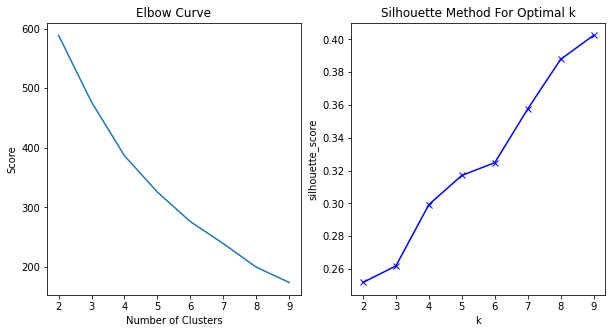

N_cluster: 2, score: 0.2518152915788437
N_cluster: 3, score: 0.26188419594665274
N_cluster: 4, score: 0.3016237438985175
N_cluster: 5, score: 0.3158052954954325
N_cluster: 6, score: 0.3285472275203275
N_cluster: 7, score: 0.3567726130598057
N_cluster: 8, score: 0.38733199737864654
N_cluster: 9, score: 0.4022520246824372


In [ ]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(df1_scal).inertia_ for i in range(len(kmeans))]

#Visualization
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(K_clusters, score)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Score')
ax1.set_title('Elbow Curve')

sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df1_scal)
    labels = kmeans.labels_
    sil.append(silhouette_score(df1_scal, labels, metric = 'euclidean')) 

#Visualization
ax2.plot(K_sil, sil,'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette_score')
ax2.set_title('Silhouette Method For Optimal k')
plt.show()

for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(df1_scal)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df1_scal,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In [ ]:
#Aplicando Kmeans
kmeans = KMeans(n_clusters=4, random_state=1).fit(df1_scal.values)
kmeans.labels_
df1_scal['labels'] = kmeans.labels_


### Visualização de todas as dimensões originais

In [ ]:
features = df1_scal[['age', 'annual_income', 'spending_score','gender']]
fig = px.scatter_matrix(df1_scal,dimensions=features,color=df1_scal['labels'])
fig.update_traces(diagonal_visible=False)
fig.show()

### Visualizar das entradas em 3D

In [ ]:
X = df1_scal[["age", "annual_income", "spending_score","gender"]]

pca = PCA(n_components=4)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df1_scal['labels'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [ ]:
df1_scal

,age,annual_income,spending_score,gender,labels
0,-1.424569,-1.738999,-0.434801,1.128152,1
1,-1.281035,-1.738999,1.195704,1.128152,1
2,-1.352802,-1.700830,-1.715913,-0.886405,0
3,-1.137502,-1.700830,1.040418,-0.886405,3
4,-0.563369,-1.662660,-0.395980,-0.886405,0
...,...,...,...,...,...
195,-0.276302,2.268791,1.118061,-0.886405,3
196,0.441365,2.497807,-0.861839,-0.886405,0
197,-0.491602,2.497807,0.923953,1.128152,1
198,-0.491602,2.917671,-1.250054,1.128152,1


In [ ]:
#iremos plotar o boxplot para termos uma visualização e análise melhor dos clusters
df['labels'] =  df1_scal['labels']
df.head(10)

,gender,age,annual_income,spending_score,labels
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,3
4,Female,31,17,40,0
5,Female,22,17,76,3
6,Female,35,18,6,0
7,Female,23,18,94,3
8,Male,64,19,3,2
9,Female,30,19,72,3


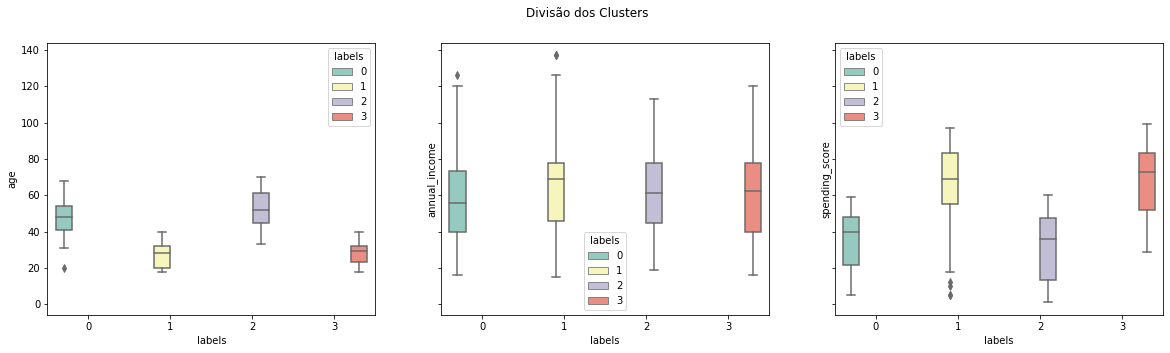

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Divisão dos Clusters')

sns.boxplot(ax=axes[0],x="labels", y='age', hue="labels",data=df, palette="Set3")
sns.boxplot(ax=axes[1],x="labels", y='annual_income', hue="labels",data=df, palette="Set3")
sns.boxplot(ax=axes[2],x="labels", y='spending_score', hue="labels",data=df, palette="Set3")

plt.show()


 A clusterização utilizando as 4 dimenções deixa claro que a principal variável na segmentação dos clientes é o gênero seguido pela idade. Não há nenhuma alternância de gênero dentro dos clusters gerados, os clusters 0 e 3 são formados exclusivamente por homens, enquanto o 1 e 2 por mulheres. Além disso, a idade também se mostrou um fator com grande relevância, os clusters 1 e 3 concentram elementos mais jovens, não possuindo nenhum com idade superior a 40 anos. A linha dois pode se tratar de um elemento excepcional, visto que está no cluster 2 que possui a maior média de idade, no entanto está fugindo do padrão com uma idade de 20 anos.

 Agora, analisando o spending score, os clusters 0 e 2 não possuem nenhum valor acima de 60, além disso o cluster 0 possui uma elevadíssima concentração de valores inferiores a 20. Já o cluster 3 possui altos valores nessa variável, possuindo apenas 4 entradas inferiores a 50, na qual uma delas é inferior a 40 (39). Já o cluster 1 possui apenas 2 entradas inferiores a 40.

 Após o teste de algumas possibilidades com diferentes valores de K, percebemos que a divisão era sempre feita baseada principalmente no gênero. O algorítimo do K-means faz a clusterização sempre pela distância euclidiana, e com isso, tendo varáveis categóricas, como gênero, ele acabou enviesando o processo fazendo com que a clusterização sempre levasse consideração o ponto máximo e mínomo da variável categórica. 

In [ ]:
df

,gender,age,annual_income,spending_score,labels
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,3
4,Female,31,17,40,0
...,...,...,...,...,...
195,Female,35,120,79,3
196,Female,45,126,28,0
197,Male,32,126,74,1
198,Male,32,137,18,1


### **Replicação do processo acima sem o gênero para verificar qual o comportamento dos dados e se haverá uma clusterização melhor**

In [ ]:
df2 = df.copy()
df2.drop(['gender','labels'], axis = 1, inplace = True) 
df2.head()

,age,annual_income,spending_score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [ ]:
scal = StandardScaler() # dados normalizados 
temp = scal.fit_transform(df2)
df2_scal = pd.DataFrame(temp,columns=df2.columns, index=df2.index)
df2_scal.head()

,age,annual_income,spending_score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


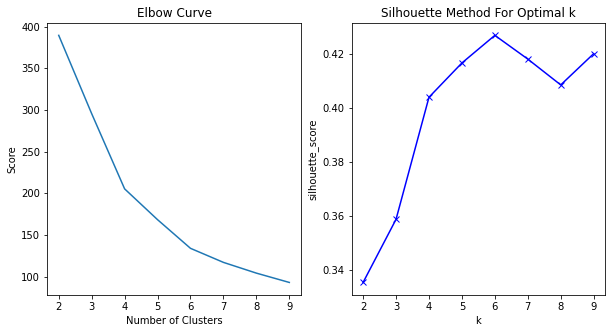

N_cluster: 2, score: 0.33547192894004574
N_cluster: 3, score: 0.357793388710272
N_cluster: 4, score: 0.4039582785148566
N_cluster: 5, score: 0.41664341513732767
N_cluster: 6, score: 0.42742814991580175
N_cluster: 7, score: 0.4188056949620008
N_cluster: 8, score: 0.41097076329037335
N_cluster: 9, score: 0.419573867483834


In [ ]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(df2_scal).inertia_ for i in range(len(kmeans))]

#Visualization
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(K_clusters, score)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Score')
ax1.set_title('Elbow Curve')

sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df2_scal)
    labels = kmeans.labels_
    sil.append(silhouette_score(df2_scal, labels, metric = 'euclidean')) 

#Visualization
ax2.plot(K_sil, sil,'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette_score')
ax2.set_title('Silhouette Method For Optimal k')
plt.show()

for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(df2_scal)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df2_scal,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In [ ]:
#Aplicando Kmeans
kmeans = KMeans(n_clusters=4, random_state=1).fit(df2_scal.values)
kmeans.labels_
df2_scal['labels'] = kmeans.labels_

In [ ]:
df2['labels'] = df2_scal['labels']

### Visualização das dimensões originais sem o gênero

In [ ]:
features = df2_scal[['age', 'annual_income', 'spending_score']]
fig = px.scatter_matrix(df2_scal,dimensions=features,color=df2_scal['labels'])
fig.update_traces(diagonal_visible=False)
fig.show()

**Visualização K-Means em 3D sem gênero**

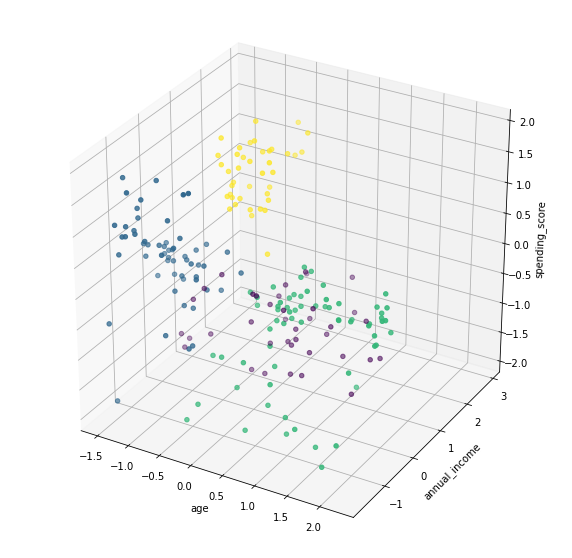

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d',)

x = df2_scal["age"]
y = df2_scal["annual_income"]
z = df2_scal[ "spending_score"]


ax.set_xlabel("age")
ax.set_ylabel("annual_income")
ax.set_zlabel("spending_score")
ax.legend

ax.scatter(x, y, z,c = df2_scal['labels'])

plt.show()

In [ ]:
df2['gender']=df['gender']
df2

,age,annual_income,spending_score,labels,gender
0,19,15,39,1,Male
1,21,15,81,1,Male
2,20,16,6,1,Female
3,23,16,77,1,Female
4,31,17,40,1,Female
...,...,...,...,...,...
195,35,120,79,3,Female
196,45,126,28,0,Female
197,32,126,74,3,Male
198,32,137,18,0,Male


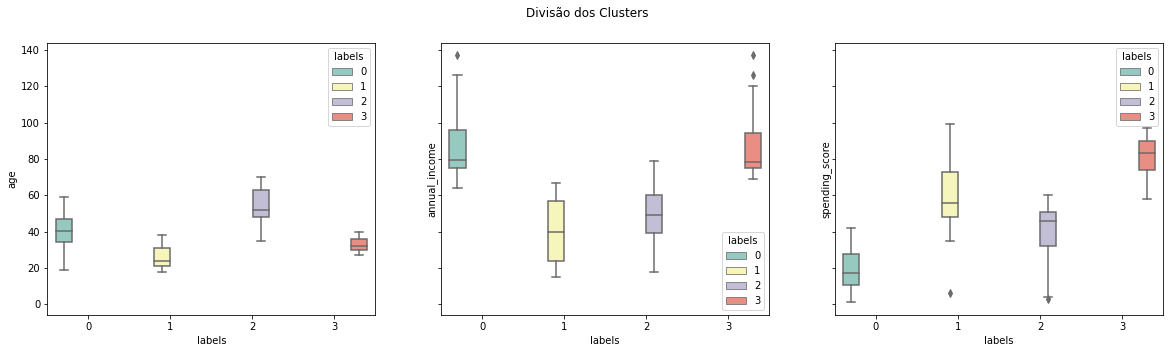

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Divisão dos Clusters')

sns.boxplot(ax=axes[0],x="labels", y='age', hue="labels",data=df2, palette="Set3")
sns.boxplot(ax=axes[1],x="labels", y='annual_income', hue="labels",data=df2, palette="Set3")
sns.boxplot(ax=axes[2],x="labels", y='spending_score', hue="labels",data=df2, palette="Set3")

plt.show()


In [ ]:
df2.groupby('labels')['spending_score'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,38.0,19.58,11.68,1.0,10.5,17.0,27.75,42.0
1,57.0,60.30,18.43,6.0,48.0,56.0,73.00,99.0
2,65.0,39.97,16.41,3.0,32.0,46.0,51.00,60.0
3,40.0,81.53,10.00,58.0,74.0,83.0,90.00,97.0


O cluster 2 possui o maior número de dados e o 0 o menor. O cluster 0 possui os menores valores do score em todas as instâncias demonstradas. O cluster 3 possui a maior média de score e diferentemente do outro cluster de score elevado o 3 não possui valores baixos, o mínimo é de 58, já o cluster 1 apesar da alta média possui uma variância maior possuindo valores baixos como 6.

In [ ]:
df2.groupby('labels')['annual_income'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,38.0,86.50,16.76,64.0,75.25,79.5,96.0,137.0
1,57.0,40.00,17.03,15.0,24.00,40.0,57.0,67.0
2,65.0,47.71,14.65,18.0,39.00,49.0,60.0,79.0
3,40.0,86.10,16.34,69.0,74.75,78.5,94.0,137.0


Os clusters 0 e 3 são quase idênticos no que se refere a renda anual, é interessante notar que no que se refere ao spending score eles são os clusters mais diferentes entre si. Voltando a renda anual possuem valores medianos e os desvios padrões de todos os clusters se mantiveram próximos.

In [ ]:
df2.groupby('labels')['age'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,38.0,39.37,10.62,19.0,34.0,40.5,46.75,59.0
1,57.0,25.44,5.71,18.0,21.0,24.0,31.00,38.0
2,65.0,53.98,9.42,35.0,48.0,52.0,63.00,70.0
3,40.0,32.88,3.86,27.0,30.0,32.0,36.00,40.0


O cluster 2 é o que possui a maior média de idade (53,98), o valor mínimo de idade nesse cluster é próximo da idade máxima dos clusters 1 e 3. O cluster 1 possui a menor média de idade, de 25,44. Os clusters 1 e 3 são os que tem o maior desvio padrão, logo possuem a maior variança entre as entradas, enquanto o cluster 3 possui uma variância muito baixa.

In [ ]:
df2.groupby('labels')['gender'].describe().round(2)

,count,unique,top,freq
labels,,,,
0,38,2,Female,19
1,57,2,Female,34
2,65,2,Female,37
3,40,2,Female,22


Os clusters 1 e 2 possuem uma proporção um pouco maior de mulheres do que o a relação original do dataset. Enquanto isso os datasets 0 e 3 possuem uma proporção consideravelmente maior de homens do que  a relação original, principalmente o cluster 3, é possível notar então que existe nele uma presença dominante de homens.

### **Aplicando  Kmeans com os dados dois a dois para verificar a forma de clusterização**

In [ ]:
df4 = df1_scal.copy()
df4.drop('labels', axis = 1, inplace = True) 
df4.head()

,age,annual_income,spending_score,gender
0,-1.424569,-1.738999,-0.434801,1.128152
1,-1.281035,-1.738999,1.195704,1.128152
2,-1.352802,-1.700830,-1.715913,-0.886405
3,-1.137502,-1.700830,1.040418,-0.886405
4,-0.563369,-1.662660,-0.395980,-0.886405


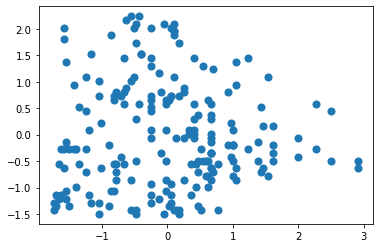

In [ ]:
#AGE x ANNUAL INCOME
plt.scatter(df4['annual_income'],df4['age'],  s=50, cmap='viridis')

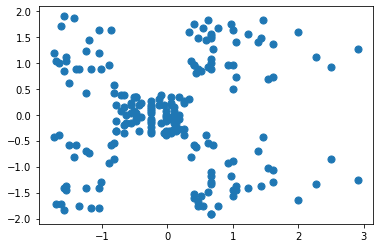

In [ ]:
#ANNUAL INCOME x SPENDING SCORE
plt.scatter(df4['annual_income'],df4['spending_score'],  s=50, cmap='viridis')

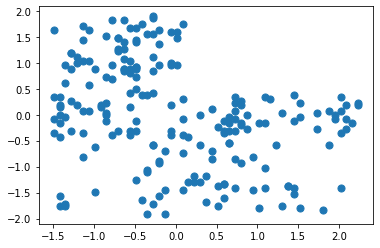

In [ ]:
#AGE x SPENDING SCORE
plt.scatter(df4['age'],df4['spending_score'],  s=50, cmap='viridis')

In [ ]:
df_age_income= df4[['age','annual_income']] 
df_age_spending= df4[['age','spending_score']] 
df_score_income= df4[['spending_score','annual_income']] 
df_gender_score= df4[['gender','spending_score']]
df_gender_income= df4[['gender','annual_income']]

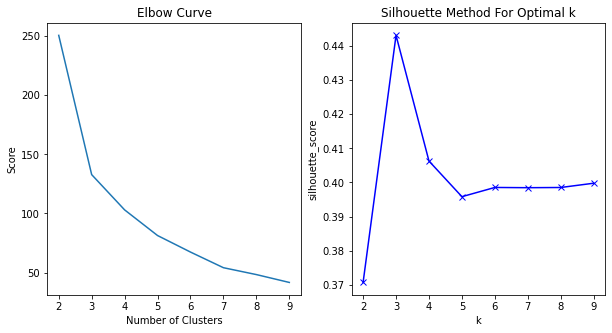

N_cluster: 2, score: 0.3706886243538429
N_cluster: 3, score: 0.4431419612216489
N_cluster: 4, score: 0.40629262670848587
N_cluster: 5, score: 0.39479552356913805
N_cluster: 6, score: 0.4016756316308602
N_cluster: 7, score: 0.4000893735246369
N_cluster: 8, score: 0.40274730135682674
N_cluster: 9, score: 0.3997045601669365


In [ ]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(df_age_income).inertia_ for i in range(len(kmeans))]

#Visualization
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(K_clusters, score)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Score')
ax1.set_title('Elbow Curve')

sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df_age_income)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_age_income, labels, metric = 'euclidean')) 

#Visualization
ax2.plot(K_sil, sil,'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette_score')
ax2.set_title('Silhouette Method For Optimal k')
plt.show()


for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(df_age_income)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df_age_income,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In [ ]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df_age_income)
kmeans.labels_
df_age_income['clusterlabels'] = kmeans.labels_


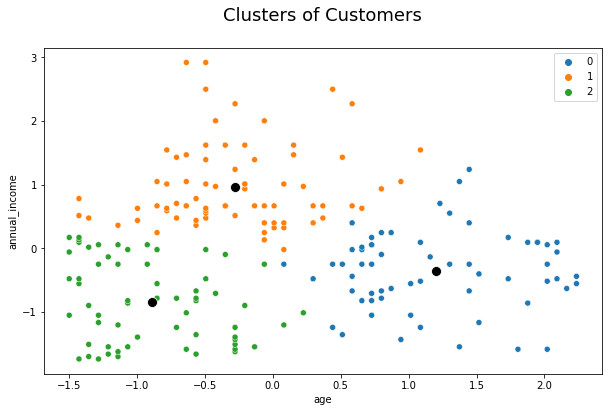

In [ ]:
clusterlabels = df_age_income['clusterlabels']
plt.figure(figsize=(10, 6))
sns.scatterplot(df_age_income['age'], df_age_income['annual_income'],hue=clusterlabels,palette=sns.color_palette("tab10",3))
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'black', s = 100)
plt.title('Clusters of Customers\n', fontsize = 18)
plt.show()

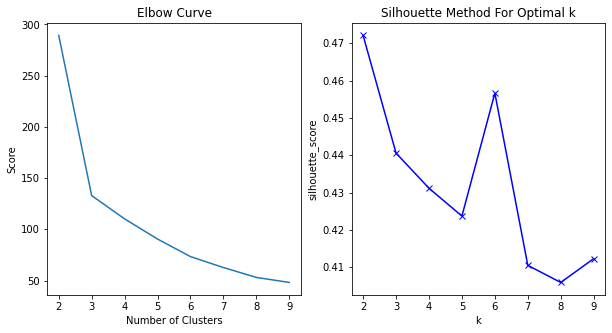

N_cluster: 2, score: 0.4721271643062346
N_cluster: 3, score: 0.43952990002101927
N_cluster: 4, score: 0.4383860846531993
N_cluster: 5, score: 0.42369111306686563
N_cluster: 6, score: 0.4566283030197353
N_cluster: 7, score: 0.4080084417950948
N_cluster: 8, score: 0.40114278778229034
N_cluster: 9, score: 0.42466622094858214


In [ ]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = [['age']]
X_axis = df_age_spending[['spending_score']]
score = [kmeans[i].fit(df_age_income).inertia_ for i in range(len(kmeans))]

#Visualization
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(K_clusters, score)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Score')
ax1.set_title('Elbow Curve')

sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df_age_spending)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_age_spending, labels, metric = 'euclidean')) 

#Visualization
ax2.plot(K_sil, sil,'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette_score')
ax2.set_title('Silhouette Method For Optimal k')
plt.show()

for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(df_age_spending)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df_age_spending,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In [ ]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df_age_spending)
kmeans.labels_
df_age_spending['clusterlabels'] = kmeans.labels_

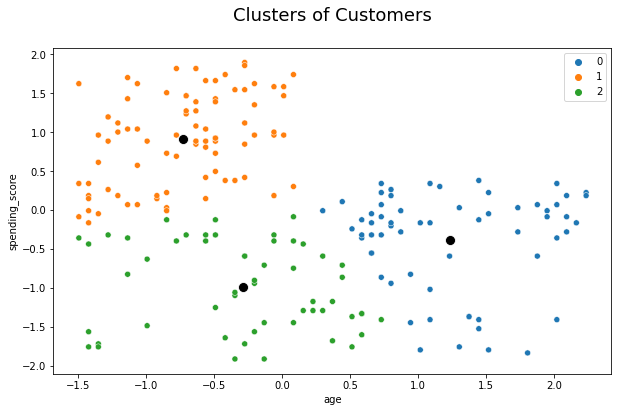

In [ ]:
clusterlabels = df_age_spending['clusterlabels']
plt.figure(figsize=(10, 6))
sns.scatterplot(df_age_spending['age'], df_age_spending['spending_score'],hue=clusterlabels,palette=sns.color_palette("tab10",3))
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'black', s = 100)
plt.title('Clusters of Customers\n', fontsize = 18)
plt.show()

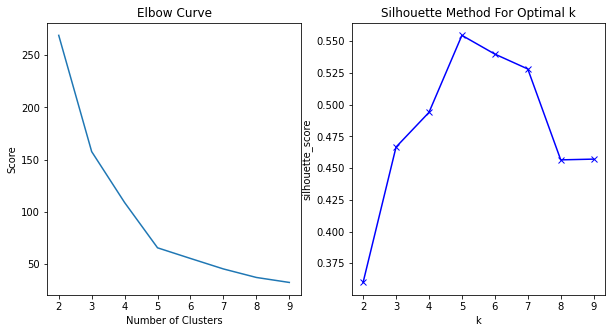

N_cluster: 2, score: 0.3093014040985521
N_cluster: 3, score: 0.46658474419000145
N_cluster: 4, score: 0.4939069237513199
N_cluster: 5, score: 0.5546571631111091
N_cluster: 6, score: 0.5398800926790663
N_cluster: 7, score: 0.5263454490712252
N_cluster: 8, score: 0.4542175096183406
N_cluster: 9, score: 0.45360667115811154


In [ ]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df_score_income[['spending_score']]
X_axis = df_score_income[['annual_income']]
score = [kmeans[i].fit(df_score_income).inertia_ for i in range(len(kmeans))]

#Visualization
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(K_clusters, score)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Score')
ax1.set_title('Elbow Curve')

sil = []
K_sil = range(2,10)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(df_score_income)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_score_income, labels, metric = 'euclidean')) 

#Visualization
ax2.plot(K_sil, sil,'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette_score')
ax2.set_title('Silhouette Method For Optimal k')
plt.show()

for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(df_score_income)
  labels_ = kmeans_.labels_
  coef = silhouette_score(df_score_income,labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

In [ ]:
#Aplicando Kmeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_score_income.values)
kmeans.labels_
df_score_income['clusterlabels'] = kmeans.labels_

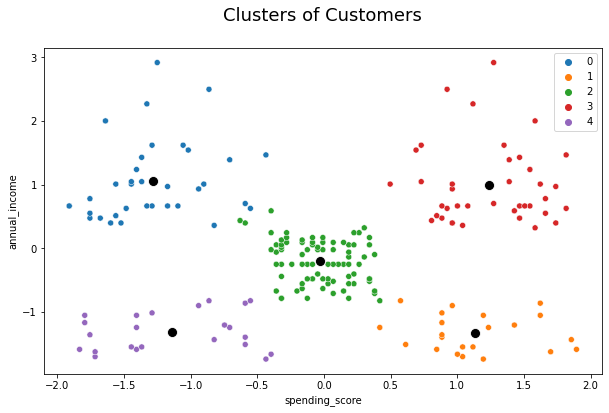

In [ ]:
clusterlabels = df_score_income['clusterlabels']
plt.figure(figsize=(10, 6))
sns.scatterplot(df_score_income['spending_score'], df_score_income['annual_income'],hue=clusterlabels,palette=sns.color_palette("tab10",5))
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'black', s = 100)
plt.title('Clusters of Customers\n', fontsize = 18)
plt.show()

### **HC**
Algoritmos de clusterização baseados no método hierárquico (HC) organizam um
conjunto de dados em uma estrutura hierárquica de acordo com a proximidade entre os
indivíduos. Os resultados de um algoritmo HC são normalmente mostrados como uma
árvore binária ou dendograma, que é uma árvore que iterativamente divide a base de
dados em subconjuntos menores. A raiz do dendograma representa o conjunto de dados
inteiro e os nós folhas representam os indivíduos. O resultado da clusterização pode ser
obtido cortando-se o dendograma em diferentes níveis de acordo com o numero de
cluster k desejado. Esta forma de representação fornece descrições informativas e
visualização para as estruturas de grupos em potencial, especialmente quando há
realmente relações hierárquicas nos dados como, por exemplo, dados de pesquisa sobre
evolução de espécies. Em tais hierarquias, cada nó da árvore representa um cluster da
base de dados.

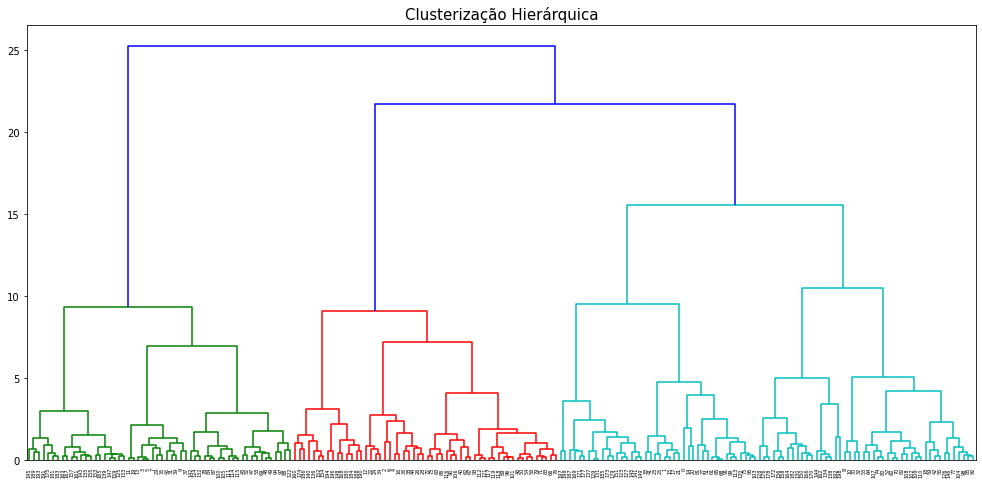

In [ ]:
plt.figure(figsize = (17, 8))
dendo = dendrogram(linkage(df1_scal.values, method = 'ward'))
plt.title('Clusterização Hierárquica', fontsize = 15)
plt.show()

### **PCA**


Análise de componente principal(PCA) é um método de redução de dimensionalidade frequentemente usado para reduzir a dimensionalidade de grandes conjuntos de dados, transformando um grande conjunto de variáveis em um menor que ainda contém a maioria das informações do grande original. Reduzir o número de variáveis de um conjunto de dados naturalmente vem às custas da precisão, assim o objetivo é ter uma baixa redução na precisão para gerar um grande aumento na simplicidade e praticidade da análise.


In [ ]:
df_pca = df1.copy()
df_pca.head()


,age,annual_income,spending_score,gender
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


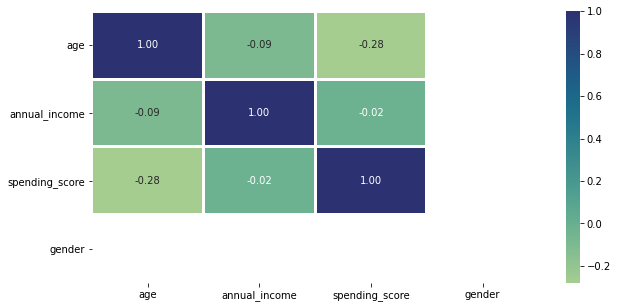

In [ ]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(df_pca), columns=df_pca.columns, index=df_pca.index)

plt.figure(figsize=(10,5))
sns.heatmap(scaled_data1.corr(),annot=True,cmap="crest",fmt='.2f',linewidths=2)
plt.show()

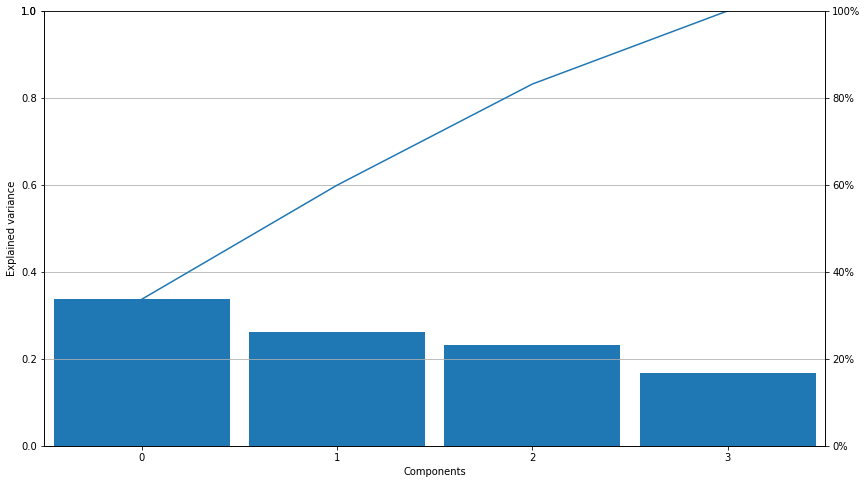

In [ ]:
pca = PCA(n_components=4)
pca.fit(scaled_data)
fig, ax = plt.subplots(figsize=(14, 8))
pareto(pca.explained_variance_ratio_)
ax.set_xlabel('Components')
ax.set_ylabel('Explained variance')
plt.grid()


In [ ]:
np.round(pca.explained_variance_ratio_.cumsum(),2)

array([0.34, 0.6 , 0.83, 1.  ])

In [ ]:
pca = PCA(n_components=2) 
df_pca1 = pd.DataFrame(pca.fit_transform(scaled_data), index=scaled_data.index, columns=['PC1', 'PC2'])
df_pca1.head()

,PC1,PC2
0,-0.406383,-0.520714
1,-1.427673,-0.367310
2,0.050761,-1.894068
3,-1.694513,-1.631908
4,-0.313108,-1.810483


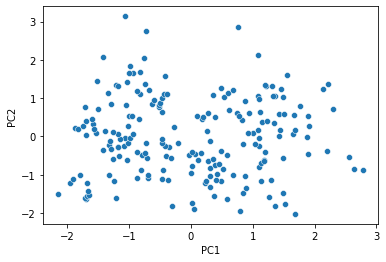

In [ ]:
sns.scatterplot(data=df_pca1, x= 'PC1',y='PC2')
plt.show()

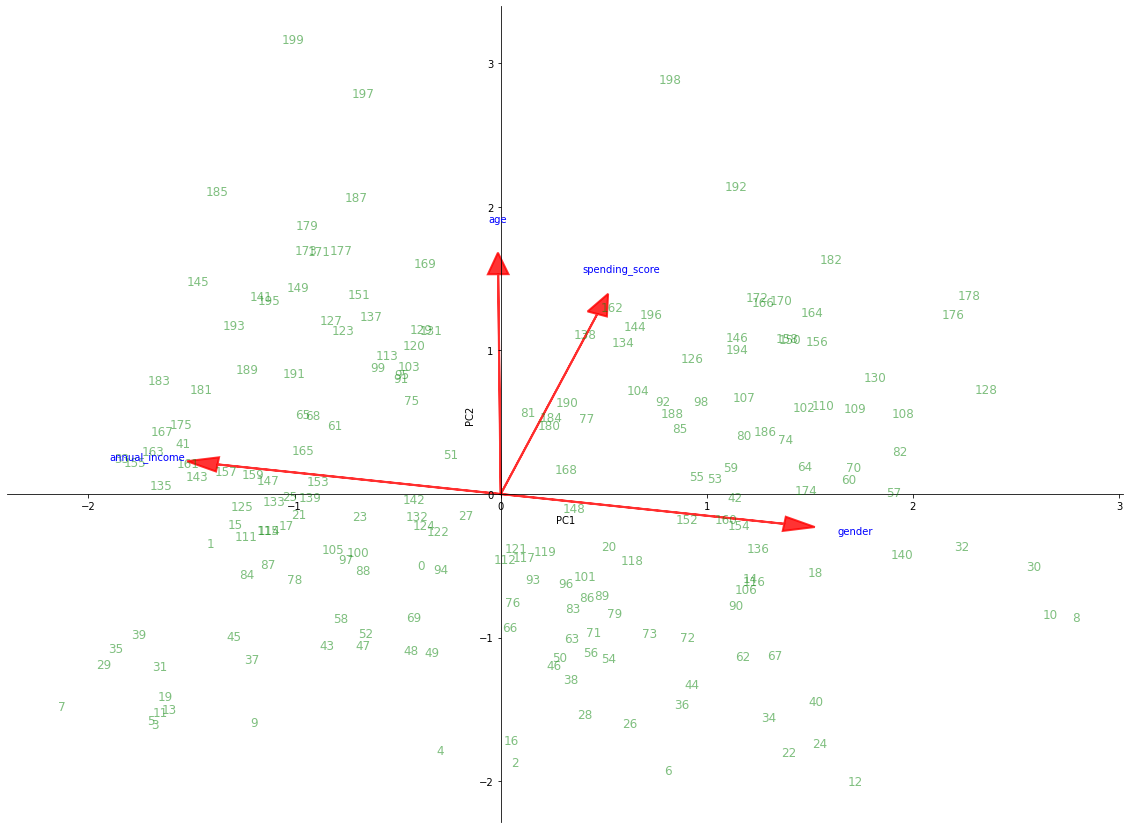

In [ ]:
def plot_components(coeff, ax,labels=None):
  for i in range(coeff.shape[0]):
        ax.arrow(0, 0, coeff[i,0]* 2, coeff[i,1]* 2, color = 'r',alpha = 0.8, lw=2, head_width=.1)
        if labels is None:
            ax.text(coeff[i,0]* 2.5, coeff[i,1] * 2.5, "Var"+str(i+1), color = 'b', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 2.5, coeff[i,1] * 2.5, labels[i], color = 'b', ha = 'center', va = 'center')


fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

df_pca2 = pd.DataFrame(pca.fit_transform(scaled_data), index=df.index, columns=['PC1', 'PC2'])

sns.scatterplot(data=df_pca2, x="PC1", y="PC2", alpha=0)

for idx in range(df_pca2.shape[0]):
  ax.text(x=df_pca2.PC1[idx],y=df_pca2.PC2[idx],s=df_pca2.index[idx], 
          fontdict=dict(color='g', size=12), alpha=.5)

plot_components(pca.components_.T, ax, labels=df.columns)


**Análise PCA**


O gráfico de correlações mostra as variáveis com uma baixa correlação, apenas a idade e o spending_score apresentam uma correlação inversamente proporcional e significativa.
O grafico de pareto apontou que as 4 variáveis representam um volume de informações relevante (0,34; 0,26; 0,23; e 0,17). Como o objetivo inicial era diminuir o número de dimensões com uma pequena diminuição na precisão, optamos por não aplicar a PCA, pois qualquer simplificação acarretaria em um grande volume de informações perdidas.
O gráfico, das componentes aponta uma correlação inversa quase total entre gênero e renda anual. Já a idade acompanha o eixo Y sendo quase inteiramente representada pela PC2. Por último o spending_score é apontado como possuindo uma relação com a idade e uma correlação mais fraca com o gênero. É importante notar que os insights gerados por esse último gráfico não são muito confiáveis, visto que o pareto demonstrou que a redução para 2 dimensões que foi utilizada contém apenas 60% das informações. Essa confiabilidade duvidosa é reforçado quando se compara os insights, gerados pelos gráficos de correlação e das componentes, pois a principal correlação do último(gender x anual_income) não existe no primeiro.
O gráfico das componentes aponta uma correlação inversa quase total entre gênero e renda anual. Já a idade acompanha o eixo Y sendo


# **4.Conclusão<a name="conclusao"></a>**

Na primeira segmentação utilizando o algoritmo mais recomendado pela literatura, percebeu-se que independente do número de clusters selecionados a variável gênero sempre era a primeira variável a ser considerada, ou seja, o resultado foram dois clusters (0 e 3) compostos exclusivamente por mulheres e os outros dois (1 e 2) exclusivamente por homens. Além disso foi possível notar uma segmentação também por idade e por spending score. O cluster 0 e 3 possuem idades médias e baixas e os 1 e 2 possuem idades médias e altas. Quanto ao spending score o cluster 0 e 2 apresentam médio e baixo valor nessa variável e o 3 apresenta valores médios e altos, o cluster 1 também apresenta valores médios e altos em sua maioria, no entanto possui alguns outliers de valores baixos.

O algorítimo do K-means faz a clusterização sempre pela distância euclidiana, e com isso, tendo varáveis categóricas, como gênero, ele acabou enviesando o processo fazendo com que a clusterização sempre levasse consideração o ponto máximo e mínimo da variável categórica. Por isso fizemos uma nova aplicação do K-means retirando a variável categórica. Como resultado tivemos clusters com ambos os gêneros. Comparado ao dataset original os clusters 1 e 2 tiveram uma proporção levemente maior de mulheres, enquanto o 0 e principalmente o 3 apresentaram uma relação maior de homens. Todos apresentaram baixa dispersão na variável idade.

No spending score o cluster 3 possui o maior nível de gastos, acompanhado pelo cluster 1. O Cluster tem um spending score intermediário entre os maiores valores e os menores do cluster 0. Se tratando de renda anual os clusters 0 e 3 possuem comportamento muito semelhante em todos os aspectos, possuindo os maiores valores, já os clusters 1 e 2 possuem valores médios e intermediários, com o cluster 1 apresentando uma maior variabilidade. Quanto a idade o cluster 2 possui a maior média (53,98), o valor mínimo de idade nesse cluster é próximo da idade máxima dos clusters 1 e 3. 

Foi analisado a possibilidade de reduzir as dimensões utilizando o PCA, no entanto os resultados não foram positivos. Trazendo um grande aumento na perda de informação em um dataset que já possuía inicialmente um volume limitado.


Um dos métodos convencionais de agrupamento comumente usados em técnicas de agrupamento e eficientemente usados para grandes dados é o algoritmo K-Means. No entanto, seu método não é bom e adequado para dados que contêm variáveis categóricas. Esse problema ocorre quando a função de custo em K-Médias é calculada usando a distância euclidiana que só é adequada para dados numéricos. Embora o K-Mode seja adequado apenas para dados categóricos, não para tipos de dados mistos. Diante desses problemas, Huang propôs um algoritmo denominado K-Prototype que é criado para tratar algoritmos de agrupamento com os tipos de dados mistos (variáveis numéricas e categóricas). K-Prototype é um método de agrupamento baseado em particionamento. Seu algoritmo é uma melhoria do algoritmo de clustering K-Means e K-Mode para lidar com o clustering com os tipos de dados mistos. Em análises realizadas futuras aconselhamos a utilização do K-prototype para conseguir fazer uma análise mais precisa da variável categórica.
